# **Load Data**

In [ ]:
# Import data and library
import os
import zipfile
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from math import sqrt
from scipy import stats
from sklearn.model_selection import GridSearchCV

os.environ['KAGGLE_USERNAME'] = 'ordacelore'
os.environ['KAGGLE_KEY'] = '6c7cecf1731724d63431f5763d0ef91c'

dataset = 'amirmahdiabbootalebi/salary-by-job-title-and-country'
os.system(f'kaggle datasets download -d {dataset}')

zip_file = dataset.split('/')[1] + '.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:zip_ref.extractall('.')

# **Explore Data**

In [ ]:
# Parse Data
df = pd.read_csv('Salary.csv')
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,32.0,Male,1,Software Engineer,5.0,90000.0,UK,White,0
1,28.0,Female,2,Data Analyst,3.0,65000.0,USA,Hispanic,0
2,45.0,Male,3,Manager,15.0,150000.0,Canada,White,1
3,36.0,Female,1,Sales Associate,7.0,60000.0,USA,Hispanic,0
4,52.0,Male,2,Director,20.0,200000.0,USA,Asian,0


In [ ]:
# datatype check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6684 entries, 0 to 6683
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6684 non-null   float64
 1   Gender               6684 non-null   object 
 2   Education Level      6684 non-null   int64  
 3   Job Title            6684 non-null   object 
 4   Years of Experience  6684 non-null   float64
 5   Salary               6684 non-null   float64
 6   Country              6684 non-null   object 
 7   Race                 6684 non-null   object 
 8   Senior               6684 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 470.1+ KB


In [ ]:
# statistical character
df.describe()

,Age,Education Level,Years of Experience,Salary,Senior
count,6684.000000,6684.000000,6684.000000,6684.000000,6684.000000
mean,33.610563,1.622382,8.077723,115307.175194,0.143477
std,7.595994,0.880474,6.029305,52806.810881,0.350585
min,21.000000,0.000000,0.000000,350.000000,0.000000
25%,28.000000,1.000000,3.000000,70000.000000,0.000000
50%,32.000000,1.000000,7.000000,115000.000000,0.000000
75%,38.000000,2.000000,12.000000,160000.000000,0.000000
max,62.000000,3.000000,34.000000,250000.000000,1.000000


# **Data Overview**

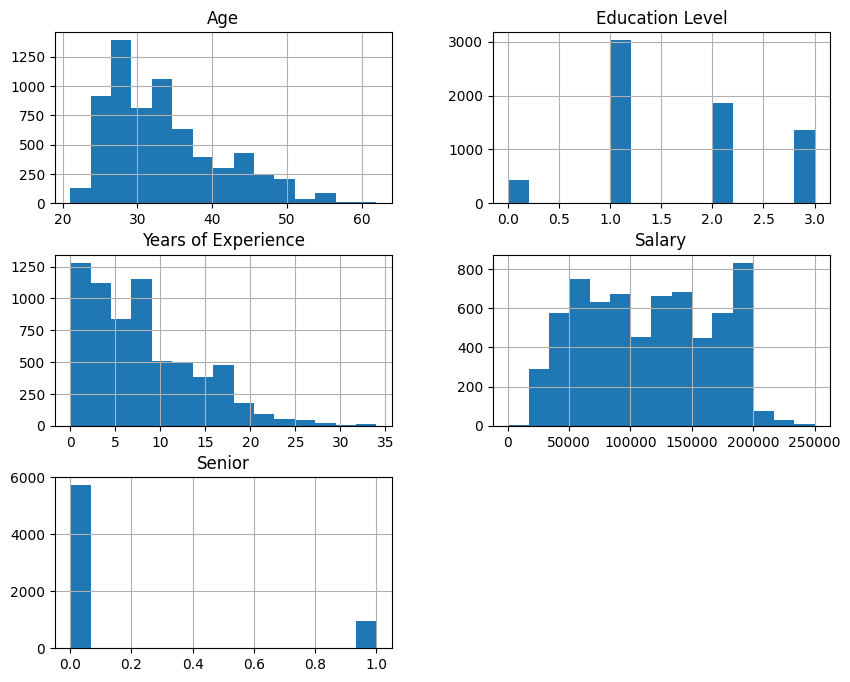

In [ ]:
num_vars = ['Age', 'Education Level', 'Years of Experience', 'Salary', 'Senior']
df[num_vars].hist(bins=15, figsize=(10, 8))
plt.show()

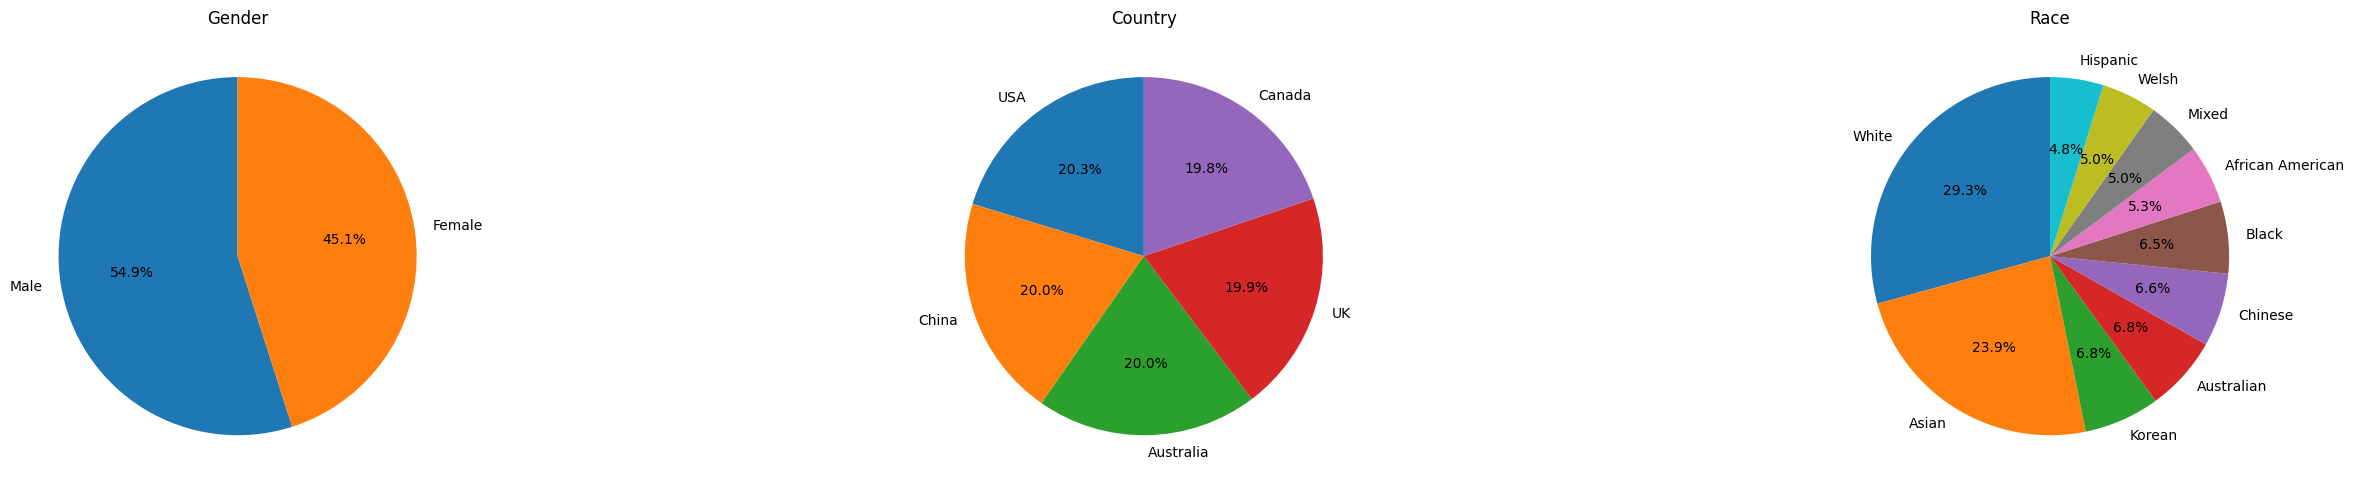

In [ ]:
cat_vars = ['Gender', 'Country', 'Race']

fig, ax = plt.subplots(1, len(cat_vars), figsize=(30, 5))
for i, var in enumerate(cat_vars):
    count = df[var].value_counts()
    ax[i].pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
    ax[i].set_title(var)

plt.tight_layout()
plt.show()

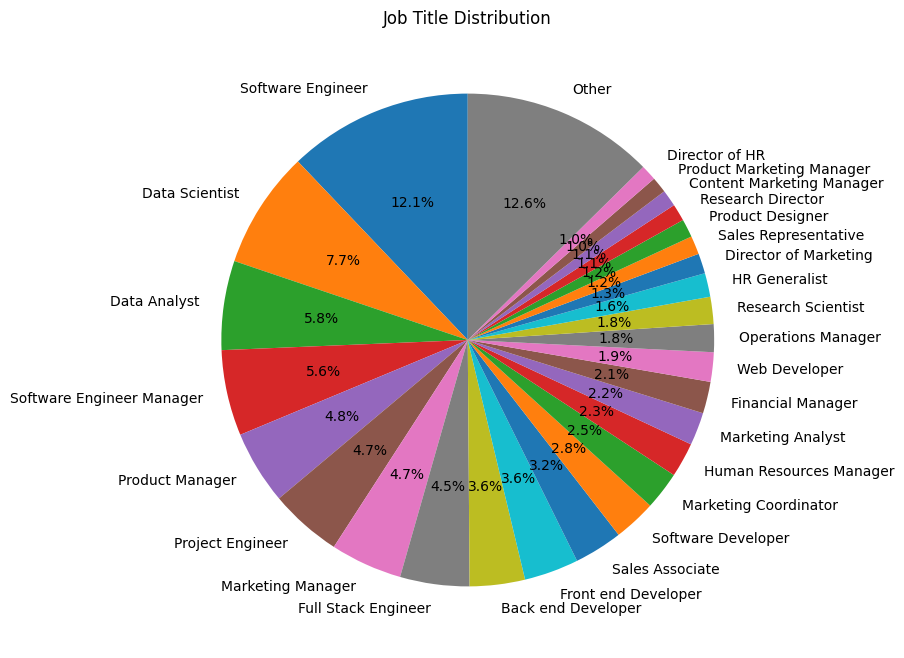

In [ ]:
threshold = 0.01
job_title_counts = df['Job Title'].value_counts(normalize=True)
mask = job_title_counts > threshold
tail = job_title_counts.loc[~mask].sum()
job_title_counts = job_title_counts.loc[mask]
job_title_counts['Other'] = tail

plt.figure(figsize=(10, 8))
plt.pie(job_title_counts, labels=job_title_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Job Title Distribution')
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

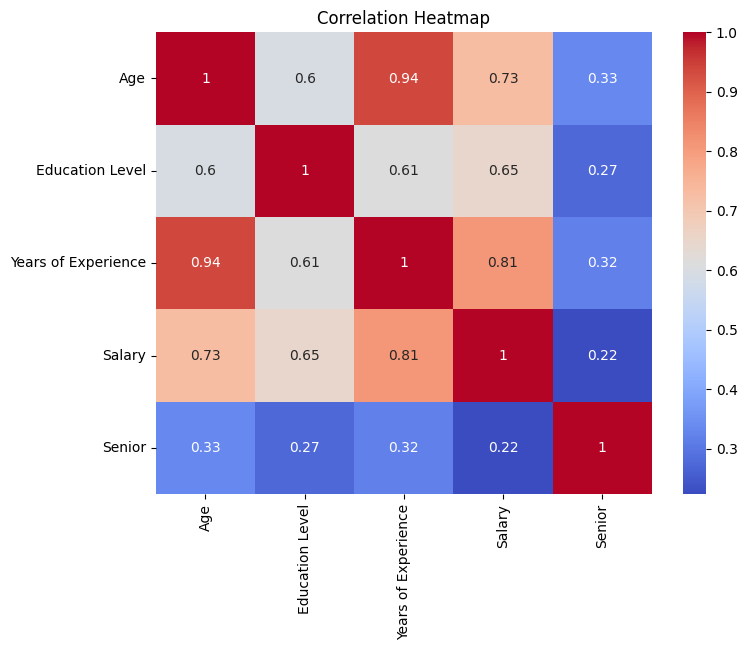

In [ ]:
# Correlation heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [ ]:
df.corr(numeric_only=True)['Salary']

,Salary
Age,0.728343
Education Level,0.645444
Years of Experience,0.810942
Salary,1.000000
Senior,0.223636


In [ ]:
%%html
<h1>Data Pre-processing</h1>

In [ ]:
# Checking missing value
df.isnull().sum()

,0
Age,0
Gender,0
Education Level,0
Job Title,0
Years of Experience,0
Salary,0
Country,0
Race,0
Senior,0


In [ ]:
# Checking incorrect values
invalid_data = df[df['Years of Experience'] > df['Age']]
print(invalid_data)

Empty DataFrame
Columns: [Age, Gender, Education Level, Job Title, Years of Experience, Salary, Country, Race, Senior]
Index: []


In [ ]:
# Checking duplicate values
df.duplicated().sum()

np.int64(1536)

In [ ]:
# Keep the duplicated values
# df = df.drop_duplicates()

In [ ]:
# Checking class Imbalance
df['Senior'].value_counts(normalize=True)

,proportion
Senior,
0,0.856523
1,0.143477


In [ ]:
df['Gender'].value_counts(normalize=True)

,proportion
Gender,
Male,0.549222
Female,0.450778


In [ ]:
df['Education Level'].value_counts(normalize=True)

,proportion
Education Level,
1,0.451975
2,0.277977
3,0.204817
0,0.065230


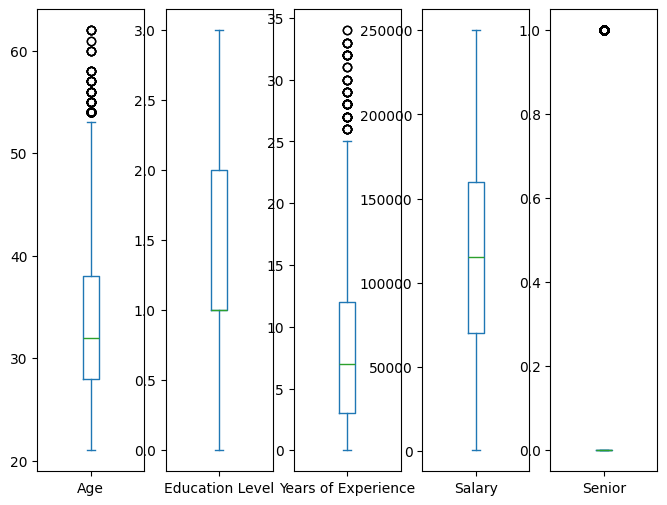

In [ ]:
# Checking outliers
# sns.boxplot(x=df['Salary'])
df[num_vars].plot(kind='box', figsize=(8, 6), subplots=True, layout=(1, 5))
plt.show()

In [ ]:
# Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[['Age', 'Education Level', 'Years of Experience','Salary','Senior']]
X = add_constant(X)
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)
# Since the VIF value of 'Years of Experience' is more than 10, it should be removed if we use linear regression. If we just predict one's position, there is no need to delete.

               Feature        VIF
0                const  98.077340
1                  Age   8.707515
2      Education Level   1.846969
3  Years of Experience  11.652217
4               Salary   3.405238
5               Senior   1.144540


In [ ]:
%%html
<h1>Model Training</h1>

In [ ]:
# Separate target variable and other variables
X = df.drop(['Salary', 'Age'], axis=1)
y = df['Salary']

X = pd.get_dummies(X, columns=['Gender', 'Job Title', 'Country', 'Race'])

# Split training and testing data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
%%html
<h2>Linear Regression Model</h2>

In [ ]:
# Linear Regression Model

model_lr = LinearRegression()
model_lr.fit(train_X, train_y)

pred_train_lr = model_lr.predict(train_X)
train_rmse_lr = np.sqrt(mean_squared_error(train_y, pred_train_lr))
train_r2_lr = r2_score(train_y, pred_train_lr)

pred_test_lr = model_lr.predict(test_X)
test_rmse_lr = np.sqrt(mean_squared_error(test_y, pred_test_lr))
test_r2_lr = r2_score(test_y, pred_test_lr)

print("=== Linear Regression Evaluation ===")
print(f"Training Set → RMSE: {train_rmse_lr:.2f}, R²: {train_r2_lr:.4f}")
print(f"Testing Set  → RMSE: {test_rmse_lr:.2f}, R²: {test_r2_lr:.4f}")

=== Linear Regression Evaluation ===
Training Set → RMSE: 22142.24, R²: 0.8246
Testing Set  → RMSE: 22404.48, R²: 0.8189


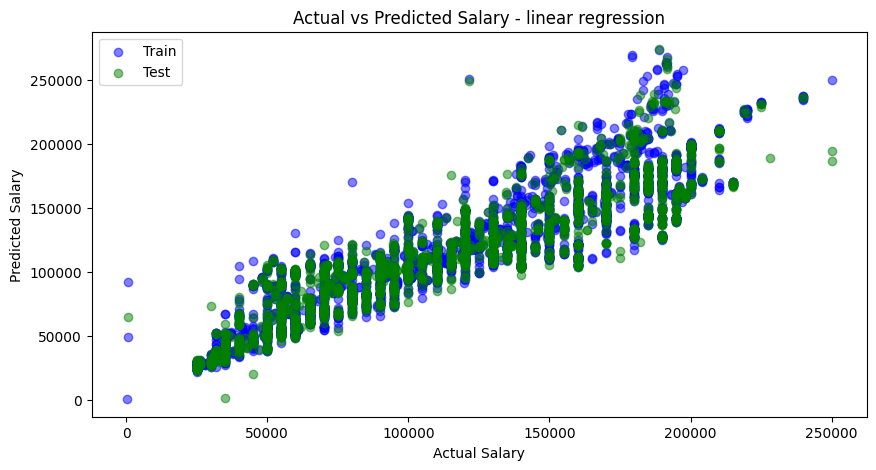

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(train_y, pred_train_lr, color='blue', alpha=0.5, label='Train')
plt.scatter(test_y, pred_test_lr, color='green', alpha=0.5, label='Test')
plt.title('Actual vs Predicted Salary - linear regression')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.legend()
plt.show()

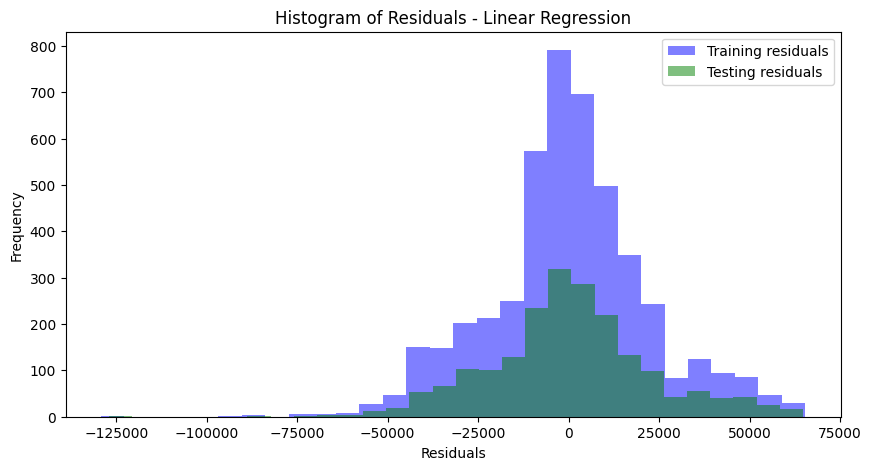

In [ ]:
residuals_train = train_y - pred_train_lr
residuals_test = test_y - pred_test_lr

plt.figure(figsize=(10, 5))
plt.hist(residuals_train, bins=30, color='blue', alpha=0.5, label='Training residuals')
plt.hist(residuals_test, bins=30, color='green', alpha=0.5, label='Testing residuals')
plt.title('Histogram of Residuals - Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
%%html
<h2>Lasso Regression Model</h2>

In [ ]:
# Lasso Regression Model

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

model_lasso = Lasso(alpha=0.1, max_iter=50000)
model_lasso.fit(train_X_scaled, train_y)

pred_train_lasso = model_lasso.predict(train_X_scaled)
train_rmse_lasso = np.sqrt(mean_squared_error(train_y, pred_train_lasso))
train_r2_lasso = r2_score(train_y, pred_train_lasso)

pred_test_lasso = model_lasso.predict(test_X_scaled)
test_rmse_lasso = np.sqrt(mean_squared_error(test_y, pred_test_lasso))
test_r2_lasso = r2_score(test_y, pred_test_lasso)

print("=== Lasso Regression Evaluation ===")
print(f"Training Set → RMSE: {train_rmse_lasso:.2f}, R²: {train_r2_lasso:.4f}")
print(f"Testing Set  → RMSE: {test_rmse_lasso:.2f}, R²: {test_r2_lasso:.4f}")

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(train_y, pred_train_lasso, color='coral', alpha=0.5, label='Train')
plt.scatter(test_y, pred_test_lasso, color='purple', alpha=0.5, label='Test')
plt.title('Actual vs Predicted Salary - Lasso Regression')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.legend()
plt.show()

In [ ]:
residuals_train_lasso = train_y - pred_train_lasso
residuals_test_lasso = test_y - pred_test_lasso

plt.figure(figsize=(10, 5))
plt.hist(residuals_train_lasso, bins=30, color='coral', alpha=0.5, label='Training residuals')
plt.hist(residuals_test_lasso, bins=30, color='purple', alpha=0.5, label='Testing residuals')
plt.title('Histogram of Residuals - Lasso Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
%%html
<h2>ElasticNet regression model</h2>

In [ ]:
# ElasticNet Regression Model

model_enet = ElasticNet(alpha=0.01)
model_enet.fit(train_X, train_y)

pred_train_enet = model_enet.predict(train_X)
train_rmse_enet = np.sqrt(mean_squared_error(train_y, pred_train_enet))
train_r2_enet = r2_score(train_y, pred_train_enet)

pred_test_enet = model_enet.predict(test_X)
test_rmse_enet = np.sqrt(mean_squared_error(test_y, pred_test_enet))
test_r2_enet = r2_score(test_y, pred_test_enet)

print("=== ElasticNet Regression Evaluation ===")
print(f"Training Set → RMSE: {train_rmse_enet:.2f}, R²: {train_r2_enet:.4f}")
print(f"Testing Set  → RMSE: {test_rmse_enet:.2f}, R²: {test_r2_enet:.4f}")

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(train_y, pred_train_enet, color='brown', alpha=0.5, label='Train')
plt.scatter(test_y, pred_test_enet, color='gold', alpha=0.5, label='Test')
plt.title('Actual vs Predicted Salary - ElasticNet Regression')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.legend()
plt.show()

In [ ]:
residuals_train_enet= train_y - pred_train_enet
residuals_test_enet = test_y - pred_test_enet

plt.figure(figsize=(10, 5))
plt.hist(residuals_train_enet, bins=30, color='brown', alpha=0.5, label='Training residuals')
plt.hist(residuals_test_enet, bins=30, color='gold', alpha=0.5, label='Testing residuals')
plt.title('Histogram of Residuals - ElasticNet Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
%%html
<h2>Random Forest Regressor</h2>

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(train_X, train_y)

pred_train_rf = rf_model.predict(train_X)
train_rmse_rf = np.sqrt(mean_squared_error(train_y, pred_train_rf))
train_r2_rf = r2_score(train_y, pred_train_rf)

pred_test_rf = rf_model.predict(test_X)
test_rmse_rf = np.sqrt(mean_squared_error(test_y, pred_test_rf))
test_r2_rf = r2_score(test_y, pred_test_rf)

print("=== Random Forest Regression Evaluation ===")
print(f"Training Set → RMSE: {train_rmse_rf:.2f}, R²: {train_r2_rf:.4f}")
print(f"Testing Set  → RMSE: {test_rmse_rf:.2f}, R²: {test_r2_rf:.4f}")

In [ ]:
feature_names = train_X.columns

importances = rf_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:top_n][::-1], feat_imp_df['Importance'][:top_n][::-1])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Important Features - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
feat_imp_df['Original_Feature'] = feat_imp_df['Feature'].str.split('_').str[0]
feat_imp_df.groupby('Original_Feature')['Importance'].sum().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(train_y, pred_train_rf, color='black', alpha=0.5, label='Train')
plt.scatter(test_y, pred_test_rf, color='green', alpha=0.5, label='Test')
plt.title('Actual vs Predicted Salary - Random Forest Regressor')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.legend()
plt.show()

In [ ]:
residuals_train_enet= train_y - pred_train_rf
residuals_test_enet = test_y - pred_test_rf

plt.figure(figsize=(10, 5))
plt.hist(residuals_train_enet, bins=30, color='black', alpha=0.5, label='Training residuals')
plt.hist(residuals_test_enet, bins=30, color='green', alpha=0.5, label='Testing residuals')
plt.title('Histogram of Residuals - Random Forest Regressor')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train_X, train_y)

print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

In [ ]:
best_rf_model = grid_search.best_estimator_

pred_test_best_rf = best_rf_model.predict(test_X)
test_rmse = np.sqrt(mean_squared_error(test_y, pred_test_best_rf))
test_r2 = r2_score(test_y, pred_test_best_rf)

print(f"Optimized RF → RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")